In [1]:
# Dependencies and Setup
import pandas as pd 
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Pull CSV
salary_df = pd.read_csv("Resources/salaries_1985to2018.csv")
salary_df.head()

,index,league,player_id,salary,season,season_end,season_start,team
0,0,NBA,abdelal01,395000,1990-91,1991,1990,Portland Trail Blazers
1,1,NBA,abdelal01,494000,1991-92,1992,1991,Portland Trail Blazers
2,2,NBA,abdelal01,500000,1992-93,1993,1992,Boston Celtics
3,3,NBA,abdelal01,805000,1993-94,1994,1993,Boston Celtics
4,4,NBA,abdelal01,650000,1994-95,1995,1994,Sacramento Kings


In [3]:
# Create DATE column for merging later
salary_df["DATE"] = pd.to_datetime(salary_df["season_start"].astype(str)+ "-01-01")
salary_df.head()

,index,league,player_id,salary,season,season_end,season_start,team,DATE
0,0,NBA,abdelal01,395000,1990-91,1991,1990,Portland Trail Blazers,1990-01-01
1,1,NBA,abdelal01,494000,1991-92,1992,1991,Portland Trail Blazers,1991-01-01
2,2,NBA,abdelal01,500000,1992-93,1993,1992,Boston Celtics,1992-01-01
3,3,NBA,abdelal01,805000,1993-94,1994,1993,Boston Celtics,1993-01-01
4,4,NBA,abdelal01,650000,1994-95,1995,1994,Sacramento Kings,1994-01-01


In [4]:
# Print unique players
print(len(salary_df["player_id"].unique()))

2408


# Adjusting for Inflation
All inflation rate is as of 09/01/2023

In [5]:
# Pull CPI CSV to adjust for inflation
cpi_data = pd.read_csv('Resources/CPIAUCNS.csv')
cpi_data.head()

,DATE,CPIAUCNS
0,1913-01-01,9.8
1,1913-02-01,9.8
2,1913-03-01,9.8
3,1913-04-01,9.8
4,1913-05-01,9.7


In [6]:
# Create new column to adjust each year to Sep. 01 2023
cpi_data['CPI_rate'] = cpi_data['CPIAUCNS'].iloc[-1]/cpi_data['CPIAUCNS']
cpi_data['DATE'] = pd.to_datetime(cpi_data['DATE'])
cpi_data.head()

,DATE,CPIAUCNS,CPI_rate
0,1913-01-01,9.8,31.407041
1,1913-02-01,9.8,31.407041
2,1913-03-01,9.8,31.407041
3,1913-04-01,9.8,31.407041
4,1913-05-01,9.7,31.730825


In [7]:
# Create Inflation Adjusted Salary column
total_salary2 = pd.merge(salary_df, cpi_data, how="left", on="DATE")
total_salary2['inflation_adjusted_salary'] = total_salary2["salary"] * total_salary2["CPI_rate"]
total_salary2.head()

,index,league,player_id,salary,season,season_end,season_start,team,DATE,CPIAUCNS,CPI_rate,inflation_adjusted_salary
0,0,NBA,abdelal01,395000,1990-91,1991,1990,Portland Trail Blazers,1990-01-01,127.4,2.415926,9.542909e+05
1,1,NBA,abdelal01,494000,1991-92,1992,1991,Portland Trail Blazers,1991-01-01,134.6,2.286694,1.129627e+06
2,2,NBA,abdelal01,500000,1992-93,1993,1992,Boston Celtics,1992-01-01,138.1,2.228740,1.114370e+06
3,3,NBA,abdelal01,805000,1993-94,1994,1993,Boston Celtics,1993-01-01,142.6,2.158408,1.737519e+06
4,4,NBA,abdelal01,650000,1994-95,1995,1994,Sacramento Kings,1994-01-01,146.2,2.105260,1.368419e+06


In [8]:
# Drop unnecessary columns
total_salary2 = total_salary2[['player_id', 'salary', 'inflation_adjusted_salary']]
total_salary2.head()

,player_id,salary,inflation_adjusted_salary
0,abdelal01,395000,9.542909e+05
1,abdelal01,494000,1.129627e+06
2,abdelal01,500000,1.114370e+06
3,abdelal01,805000,1.737519e+06
4,abdelal01,650000,1.368419e+06


In [9]:
# Group by player id and the sum of salary and inflation-adjusted salary
player_salary = total_salary2.groupby(['player_id']).sum()
player_salary.head()

,salary,inflation_adjusted_salary
player_id,,
abdelal01,2844000,6.304225e+06
abdulka01,8560000,2.406022e+07
abdulma02,19849500,4.177226e+07
abdulta01,37982800,6.558494e+07
abdursh01,95866000,1.630366e+08


In [10]:
# Print total rows
player_salary.count()

salary                       2408
inflation_adjusted_salary    2408
dtype: int64

In [11]:
# Rename player id and salary for merging
player_salary.index.rename("_id", inplace=True)
player_salary.rename(columns={"salary": "Total Earnings", "inflation_adjusted_salary": "Inflation-Adjusted Earnings"}, inplace=True)
player_salary

,Total Earnings,Inflation-Adjusted Earnings
_id,,
abdelal01,2844000,6.304225e+06
abdulka01,8560000,2.406022e+07
abdulma02,19849500,4.177226e+07
abdulta01,37982800,6.558494e+07
abdursh01,95866000,1.630366e+08
...,...,...
zidekge01,2081200,4.135382e+06
zimmest01,950000,1.234191e+06
zipsepa01,2062611,2.638045e+06


In [12]:
# Create Salary DataFrame with readable salaries
player_salary2 = player_salary.copy()
player_salary2["Total Earnings"] = player_salary2["Total Earnings"].map("${:,.2f}".format)
player_salary2["Inflation-Adjusted Earnings"] = player_salary2["Inflation-Adjusted Earnings"].map("${:,.2f}".format)
player_salary2.head()

,Total Earnings,Inflation-Adjusted Earnings
_id,,
abdelal01,"$2,844,000.00","$6,304,225.16"
abdulka01,"$8,560,000.00","$24,060,224.72"
abdulma02,"$19,849,500.00","$41,772,255.61"
abdulta01,"$37,982,800.00","$65,584,943.25"
abdursh01,"$95,866,000.00","$163,036,582.98"


In [13]:
# Push clean csv files
filepath = Path('Resources/cleaned_salary_data.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
player_salary.to_csv(filepath)

# Data Visualising

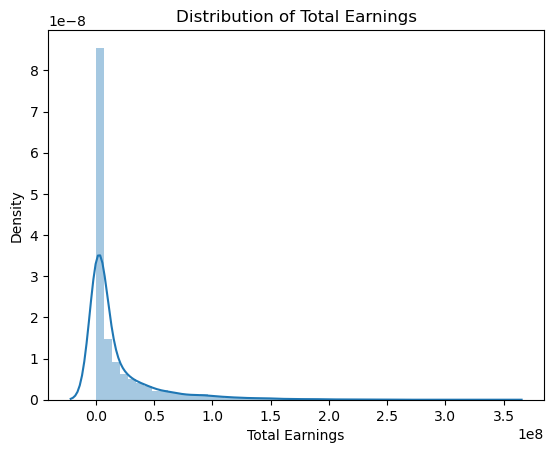

In [17]:
#Distribution of Salaries
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(player_salary['Total Earnings'])
plt.title('Distribution of Total Earnings')
plt.show()

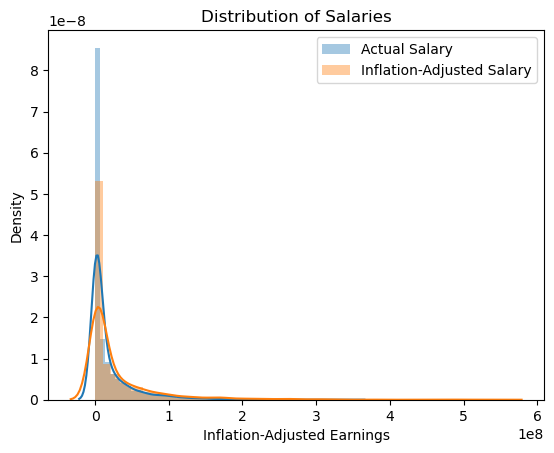

In [18]:
#Inflation-Adjusted vs. Actual Salaries
sns.distplot(player_salary['Total Earnings'], label='Actual Salary')
sns.distplot(player_salary['Inflation-Adjusted Earnings'], label='Inflation-Adjusted Salary')
plt.legend()
plt.title('Distribution of Salaries')
plt.show()

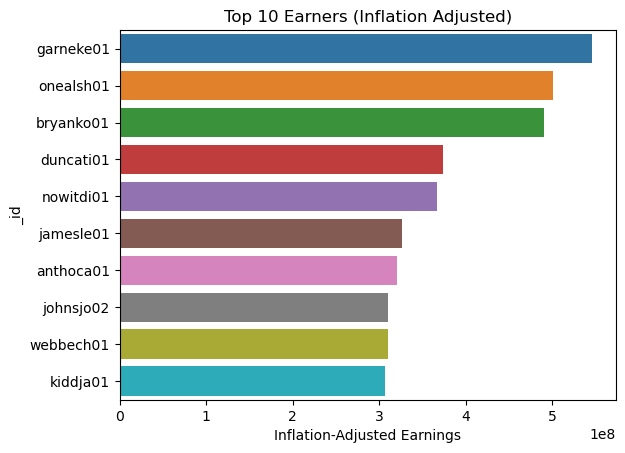

In [19]:
#Top Earners
top_earners = player_salary.nlargest(10, 'Inflation-Adjusted Earnings')
sns.barplot(data=top_earners, y=top_earners.index, x='Inflation-Adjusted Earnings')
plt.title('Top 10 Earners (Inflation Adjusted)')
plt.show()
